# Chaotic Hyperion
In this example, we simulate the spin of Hyperion. The spin evolution is governed by an ordinary differential equation that is coupled to the moon's orbit. 

We start by importing REBOUND, numpy and matplotlib.

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

The right hand side of ODEs can be implemented in either python or in C. Although not absolutely necessary for this example, we here show how to implement the RHS in C. This is often significantly faster than using a python callback function. 

We use a simple spin model which is one second order ODE, or a set of two coupled first order ODEs. For more details on the physics behind this model, see  Danby (1962), Goldreich and Peale (1966), and Wisdom and Peale (1983). The RHS of this set of ODEs implemented in C is:

In [2]:
%%writefile rhs.c
#include "rebound.h"
void derivatives(struct reb_ode* const ode, double* const yDot, const double* const y, const double t){
    struct reb_orbit o = reb_orbit_from_particle(ode->r->G, ode->r->particles[1], ode->r->particles[0]);
    
    double omega2 = 3.*0.26; 
    yDot[0] = y[1];
    yDot[1] = -omega2/(2.*o.d*o.d*o.d)*sin(2.*(y[0]-o.f));
}


Overwriting rhs.c


We now compile this into a shared library. We need the REBOUND headers and library for this. The following is a bit of hack: we just copy the files into the current folder. This works if you've installed REBOUND from the git repository. Otherwise, you'll need to find these files manually (which might depend on your python environment). 

In [3]:
!cp ../src/librebound.so .
!cp ../src/rebound.h .
!gcc -c -O3 -fPIC rhs.c -o rhs.o
!gcc -L. -shared rhs.o -o rhs.so -lrebound 

Using ctypes, we can load the library into python

In [ ]:
from ctypes import cdll
clibrhs = cdll.LoadLibrary("rhs.so")

The following function is setting up the N-body simulation as well as the ODE system that governs the spin evolution. Note that we set the `derivatives` function pointer to the C function we've just compiled. You could also set this function pointer to a python function and avoid all the C complications.

In [133]:
def setup():
    sim = rebound.Simulation()
    sim.add(m=1)             # Saturn
    sim.add(a=1, e=0.123233) # Hyperion, massless, semi-major axis of 1
    sim.integrator = "BS"
    sim.ri_bs.eps_rel = 1e-12  # tolerance
    sim.ri_bs.eps_abs = 1e-12
    
    ode_spin = sim.create_ode(length=2, needs_nbody=True)
    ode_spin.y[0] = 0.01  # initial conditions that lead to chaos
    ode_spin.y[1] = 1
    ode_spin.derivatives = clibrhs.derivatives
    
    return sim, ode_spin

We will create two simulations that are slightly offset from each other.

In [ ]:
sim, ode_spin = setup()
sim2, ode_spin2 = setup()
ode_spin2.y[0] += 1e-8 # small perturbation

With these two simulations, we can measure the growing divergence of nearby trajectories, a key feature of chaos.

In [149]:
times = 2.*np.pi*np.linspace(0,30,100) # a couple of orbits
obliq = np.zeros((len(times)))
obliq2 = obliq.copy()

for i, t in enumerate(times):
    sim.integrate(t, exact_finish_time=1)
    sim2.integrate(t, exact_finish_time=1)        
    obliq[i] = ode_spin.y[0]
    obliq2[i] = ode_spin2.y[0]

Finally, let us plot the divergence as a function of time.

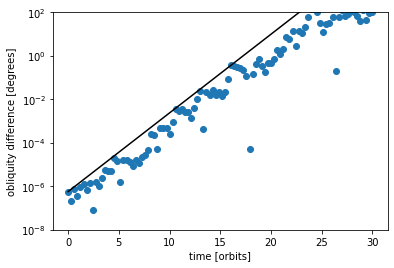

In [150]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [orbits]")
ax.set_ylabel("obliquity difference [degrees]")
ax.set_yscale("log")
ax.set_ylim([1e-8,1e2])
o1 = np.remainder((obliq-obliq2)*180/np.pi,360.)
o2 = np.remainder((obliq2-obliq)*180/np.pi,360.)
ax.scatter(times/np.pi/2.,np.minimum(o1,o2))
ax.plot(times/np.pi/2.,1e-8/np.pi*180.*np.exp(times/(np.pi*2.)/1.2),color="black");

On a log-linear scale, we see that the divergence follows a straight line, indicating exponential growth. The Lyapunov timescale is approximately 1.2 orbits. About 25 days! (Wikipedia says ~30 days which is close enough given the very simplistic model)